### Make a copy of this note if you want to analyze 

#### Please run panta first to get gene clusters and other output files for this analysis

In [1]:
## Don't use this anymore: starting using scaffolding_workflow.ipynb

In [1]:
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import sys, re
from pangraph.utils import write_fasta
from networkx import NetworkXNoPath
import os
from pangraph.utils import overlap, reverse_complement

In [2]:
def max_common_subsequene(a, b):
    result = np.zeros((len(a), len(b)))
    max_value = 0; best_max = 0
    for i in range(len(a)):
        for j in range(len(b)):
            if (a[i]==b[j]):
                result[i,j] = result[i-1,j-1]+1 #remember to initialize the borders with zeros
            else:
                result[i,j]=0
    print(np.amax(result))

In [4]:
# simversion = '_v3'
# simversion = '_Kp100random_v01'
# simversion = '_Kp500random_v03'
simversion = '_Ecoli100random_plasmid_v01'

In [11]:
# data_dir = "../panta/examples/test/output/"
# data_dir = "data/genome_graph_test/"
# you can take the data in the directory: data/genome_graph_test
# data_dir = "../panta/examples/test/output_Kp30plus1/"
# data_dir = "../panta/examples/test/output_Kp100/"
# data_dir = '/data/hoan/amromics/panta/examples/test/output_Kp100_v3/'
# data_dir = '/data/hoan/amromics/panta/examples/test/output_Kp100random_v01/'
# data_dir = '/data/hoan/amromics/panta/examples/test/output_Kp500random_v03/'
data_dir = '/data/hoan/amromics/panta/examples/test/output_Ecoli100random_plasmid_v01/'
# data_dir = "../panta/examples/test/output_Kp30mix_nosplitparalog/"
# data_dir = "../panta/examples/test/output_Kp500mix/"
# data_dir = "/data/hoan/amromics/simulation/art_output/spades_output/panta_output/"

In [12]:
sample_info = pd.read_csv(data_dir + "samples.tsv", delimiter='\t', header=None)
sample_info.columns = ['Name', 'SampleID']

In [13]:
sample_info.head(2)

,Name,SampleID
0,GCF_000010245.2_ASM1024v1_genomic,1
1,GCF_000493755.1_ASM49375v1_genomic,2


In [14]:
gene_info = pd.read_csv(data_dir + "gene_info.tsv", delimiter='\t', header=None)
gene_info.columns =['GeneName', 'SampleID', 'clusterID']

In [15]:
gene_info.head(2)

,GeneName,SampleID,clusterID
0,79_2248@1398@1,79,0
1,9_5229@1827@1,9,0


In [16]:
# for i in range(5000):
#     print(sum(gene_info.clusterID==0), end =",")

In [17]:
gene_position = pd.read_csv(data_dir + 'gene_position.tsv', delimiter='\t', header=None)
gene_position.columns =['SampleID', 'ContigName', 'GeneSequence']

In [18]:
gene_position[gene_position.SampleID==0].head(2)

,SampleID,ContigName,GeneSequence
344,0,NODE_1_length_393555_cov_18.785766,0_1@1008@-1;0_2@1167@-1;0_3@555@-1;0_4@891@-1;...
345,0,NODE_2_length_311895_cov_18.769561,0_343@1359@-1;0_344@2424@1;0_345@2019@1;0_346@...


In [19]:
# print(gene_position.ContigName.values)

In [20]:
# gene_position[gene_position.SampleID==0].head(2)

In [21]:
# sort by length of contigs
gene_position.sort_values(by="GeneSequence", key=lambda x: x.str.len(),  ascending=False, inplace=True)

In [22]:
print("List of all samples")
n_samples = len(np.unique(gene_position.iloc[:,0]))
np.unique(gene_position.iloc[:,0])

List of all samples


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

In [23]:
# ## select some sample
# selected_samples = [0, 32]
# sample_info = sample_info.loc[sample_info['SampleID'].isin(selected_samples)]
# gene_info = gene_info.loc[gene_info['SampleID'].isin(selected_samples)]
# gene_position = gene_position.loc[gene_position['SampleID'].isin(selected_samples)]

## Construct pangraph

In [24]:
%load_ext autoreload
%autoreload 2
from pangraph import PanGraph

In [25]:
# construct the pangenome graph
# min_contig_len = 100
pangraph = PanGraph(sample_info=sample_info, gene_info=gene_info, gene_position=gene_position)

In [26]:
incomplete_sample_name = "g1"
incomplete_sample_id = sample_info[sample_info.Name==incomplete_sample_name].iloc[0,1]
# H = pangraph.construct_graph(method = "graph_alignment", sample_id_ref = None,  min_nucleotides = 90, min_genes = 0, 
#                             target_genome_id=incomplete_sample_id) # use the same min_contig_len when generate the ground truth
H = pangraph.construct_graph(method = "graph_alignment", sample_id_ref = 1,  min_nucleotides = 90, min_genes = 0, target_genome_id=incomplete_sample_id) # use the same min_contig_len when generate the ground truth

Set minimum on number of nucleotides =  90 NUMBER OF COMPUTED CONTIGS: 462
Clip the matrixn 0.2 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [27]:
# nx.write_gml(H,'cytoscape_out/pan_graph.gml')

In [28]:
# number of nodes and edges
pangraph.n_clusters, H.number_of_edges()

(495308, 4913)

## Data analysis

In [29]:
from pangraph.utils import append_strand, append_strand_undirected

In [30]:
from pangraph.utils import getContigsAdjacency
edge_list_assembly = []
undirected_edge_list_assembly = []
# for l,r in getContigsAdjacency('/data/hoan/amromics/spades_quast/SAMN04158282/'):
for l,r in getContigsAdjacency('/data/hoan/amromics/simulation/art_output/spades_output' + simversion):
    # print("{} --> {}".format(l,r))
    edge_list_assembly.append((append_strand(l),append_strand(r)))
    # undirected_edge_list_assembly.append((append_strand_undirected(l), append_strand_undirected(r)))

assembly_graph= nx.DiGraph()
assembly_graph.add_edges_from(edge_list_assembly)
nx.write_gml(assembly_graph,'/data/hoan/amromics/simulation/art_output/spades_output'+simversion+'/assembly_graph.gml')

In [31]:
from pangraph.utils import buildOverlapEdge
from pangraph.utils import read_contigs2dict
gene = read_contigs2dict('/data/hoan/amromics/simulation/art_output/spades_output'+simversion+'/contigs.fasta')
# edge_list_overlap = buildOverlapEdge(gene, 20)
edge_list_overlap = buildOverlapEdge(gene, 20, 'directed')
# undirected_edge_list_overlap = buildOverlapEdge(gene, 20, 'undirected')

In [27]:
# edge_list_overlap

In [32]:
# print("Take union of two graph!!")
# edge_list_final = edge_list_overlap + edge_list_assembly
edge_list_final = edge_list_assembly
# undirected_edge_list_final =  undirected_edge_list_assembly + undirected_edge_list_overlap

In [33]:
assembly_graph= nx.DiGraph()
assembly_graph.add_edges_from(edge_list_final)
# undirected_assembly_graph= nx.Graph()
# undirected_assembly_graph.add_edges_from(undirected_edge_list_final)
nx.write_gml(assembly_graph,'/data/hoan/amromics/simulation/art_output/spades_output'+simversion+'/overlap_graph.gml')

In [35]:
L = list(nx.weakly_connected_components(assembly_graph))

In [36]:
len(L)

51

### Manual checking

In [30]:
# for idx in gene_position.iloc[:,1]:
#     if idx[:4]=='NODE':
#         print(idx, end = ',')

In [31]:
# # assembly_graph.has_edge('NODE_1_length_360583_cov_9.851928', 'NODE_2_length_327037_cov_9.679695')
# node1 = 'NODE_30_length_58501_cov_29.181877+'
# node2 = 'NODE_45_length_13325_cov_30.337076-'
# source_id = 'C-' + str(pangraph.tail_contig[node1[:-1]])
# target_id = 'C-' + str(pangraph.head_contig[node2[:-1]])  
# assembly_graph.has_node(node1), assembly_graph.has_node(node2), 

In [32]:
# # nx.shortest_path_length(assembly_graph, node1, node2)
# # nx.shortest_path_length(H, source_id, target_id)
# p = nx.shortest_path(pangraph.H, source=source_id, target=target_id)                           
# weight_p = 0.0
# for node_p_idx in range(len(p)-1):
#     weight_p += pangraph.H[p[node_p_idx]][p[node_p_idx+1]]['weight']
# weight_p = 0.05 + weight_p/float(len(p)*(len(p)-1))
# weight_p, nx.shortest_path_length(H, source_id, target_id)

In [33]:
# nx.shortest_path(assembly_graph, source=node1, target=node2)  

In [34]:
# list(assembly_graph.nodes)[0:4]

In [ ]:
# df = pd.read_csv("/data/hoan/amromics/simulation/contigs100vsref_mapping_v01.paf", sep ="\t", header=None)
# final_df0 = df.sort_values(by=[7])
# final_df = final_df0.loc[final_df0[1] >= 3000]
# sum_len = 0
# for i in range(len(final_df.index)-1):
#     if final_df.iloc[i,1] > 1000:
#         node1 = final_df.iloc[i,0]
#         node2 = final_df.iloc[i+1,0]
#         print(node1, node2)
#         source_id = 'C-' + str(pangraph.tail_contig[node1])
#         target_id = 'C-' + str(pangraph.head_contig[node2]) 
#         source_node = node1 + pangraph.strand[node1]
#         target_node = node2 + pangraph.strand[node2]
#         print(nx.has_path(pangraph.H, source_id, target_id), end = ':')
#         if assembly_graph.has_node(source_node) and assembly_graph.has_node(target_node):
#             print(nx.has_path(assembly_graph, source_node, target_node), end = ',')   
#         if nx.has_path(pangraph.H, source_id, target_id) or nx.has_path(assembly_graph, source_node, target_node):
#             sum_len += int(final_df.iloc[i,1])
#             print(sum_len, end='')
#         else:
#             print("Restart............................................")
#             sum_len = 0
#         print('\n-------------------------------------------------------------------')

In [80]:
# assembly_graph.has_node('NODE_37_length_15953_cov_15.514028+')

### Running the method

In [81]:
# graph_use = undirected_assembly_graph if graph_type=='undirected' else assembly_graph
# method = weight_path_assembly: less contigs, more strict condition on adding two nodes
# maximum_matching = (greedy, opt), opt: optimal 
## Max_length: should define in term of nucliotides.
params = {'method': 'weight_path_assembly_v2', 'assembly_graph': assembly_graph, 'max_length': 5, 'maximum_matching': 'opt', 'graph':'directed', 
          'max_length_nucleotides': 8000}
# params = {'method': 'weight_path_assembly_v2', 'assembly_graph': graph_use, 'max_length': 5, 'maximum_matching': 'greedy', 'graph':'directed'}

In [82]:
# contig_graph = pangraph.join_contig(sample_id=incomplete_sample_id, min_weight=1.0, method="edge_weight")
# contig_graph = pangraph.join_contig(sample_id=incomplete_sample_id, min_weight=1.0, method="weight_path")
# contig_graph = pangraph.remove_cycle(assembly_graph)
# contig_graph = pangraph.join_contig(sample_id=incomplete_sample_id, min_weight=1.0, method="weight_path_assembly", assembly_graph=assembly_graph, max_length=5)
contig_graph = pangraph.join_contig(sample_id=incomplete_sample_id, min_weight=1.0, params=params)
contig_graph = pangraph.remove_cycle(assembly_graph)
nx.write_gml(contig_graph,'cytoscape_out/contig_graph.gml')
nx.write_gml(contig_graph,'/data/hoan/amromics/simulation/art_output/spades_output'+simversion+'/contig_graph.gml')

Compute maximum matching


In [83]:
list(nx.simple_cycles(contig_graph))

[]

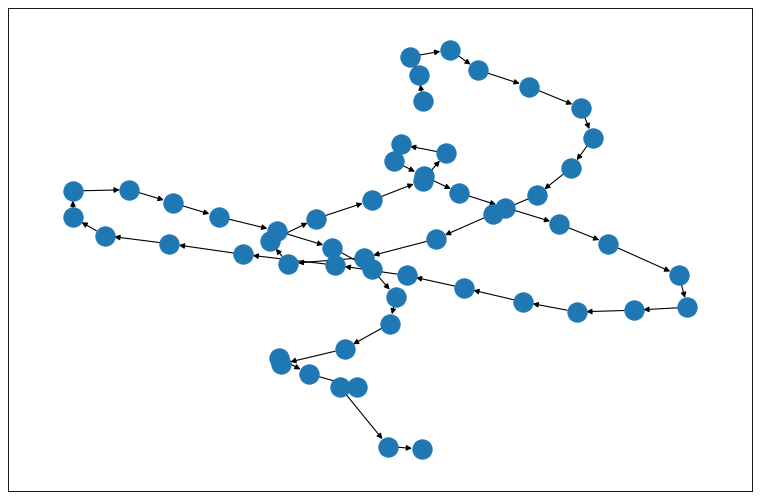

In [84]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)
nx.draw_networkx(contig_graph, arrows=True, with_labels=False)

In [85]:
indegree_dict = dict(contig_graph.in_degree())
# indegree_dict

In [86]:
adj_list = {}
for source_node_key in indegree_dict:
    if indegree_dict[source_node_key] == 0:
        adj_list[source_node_key] = []
        next_neighbor_temp = source_node_key
        while(1):
            next_neighbor_temp = list(contig_graph.neighbors(next_neighbor_temp))
            if len(next_neighbor_temp) > 0:
                next_neighbor_temp = next_neighbor_temp[0]
                adj_list[source_node_key].append(next_neighbor_temp)
            else:
                break;

In [87]:
# adj_list

In [88]:
# list(gene_position.ContigName)

In [89]:
# pangraph.gene2cluster_dict['FHLJBAOL_00001_0_1@390@+']

In [90]:
def flatten(l):
    if len(l) == 1:
        return l[0]
    else:
        return [item for sublist in l for item in sublist]
def remove_duplicate(your_list):
    return ([v for i, v in enumerate(your_list) if i == 0 or v != your_list[i-1]])

In [91]:
## neu ko la adjacent thi bat dau bang contigs moi.
adj_list_assembly = {}
for key in adj_list:
    new_key = key
    path1 = adj_list[key].copy()
    path1.insert(0, key)
    path2 = [new_key + pangraph.strand[new_key]]
    for i in range(len(path1)-1):
        src = path1[i] + pangraph.strand[path1[i]]
        dst = path1[i+1] + pangraph.strand[path1[i+1]]
        if not assembly_graph.has_node(src):
            path2.append(src)
        elif not assembly_graph.has_node(dst):
            path2.append(src)
            continue
        else:
            # print("Hi, I am here")
            if nx.has_path(assembly_graph, src, dst):
                paths = [p for p in nx.all_shortest_paths(assembly_graph, src, dst)]
                for node in paths[-1]:
                    path2.append(node)
                # paths = list(nx.all_simple_paths(assembly_graph, source=src, target=dst, cutoff=12))
                # max_path_id = 0
                # for idx in range(1, len(paths)):
                #     if len(paths[idx]) > len(paths[max_path_id]):
                #         max_path_id = idx
                # for node in paths[max_path_id]:
                #     path2.append(node)
            else:
                # print(src, dst,"___", paths[0])    
                path2.append(src)       
                print("Will test this, Ok?")
                # # construct a new path if they are disconnected on the graph
                # if len(path2) > 0:
                #     adj_list_assembly[new_key+pangraph.strand[new_key]] = remove_duplicate(path2)
                # new_key = dst[0:-1]
                # path2 = []           
    if dst not in path2:
        # print(path2)
        path2.append(dst)
    if len(path2) > 0:
        adj_list_assembly[new_key+pangraph.strand[new_key]] = remove_duplicate(path2)

Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?
Will test this, Ok?


In [92]:
# adj_list

In [93]:
# adj_list_assembly
for key in adj_list_assembly:
    for elem in adj_list_assembly[key]:
        print(elem[5:8], end='')
        print(elem[-1], end=',')
    print('')

44_-,11_+,132+,1_l+,52_+,3_l+,56_+,64_-,33_-,166-,147+,89_-,27_-,12_+,4_l+,23_+,39_-,6_l+,107+,102-,47_-,13_+,41_-,52_-,30_+,53_+,35_+,15_-,24_-,52_-,17_-,174-,19_-,185+,54_+,28_+,54_+,16_+,56_-,134-,53_-,5_l-,48_+,58_+,57_+,32_-,31_-,54_-,37_+,56_+,9_l-,22_-,38_-,57_-,50_-,25_-,29_-,34_-,54_-,18_-,40_-,61_+,65_-,49_-,21_+,20_-,46_-,10_-,56_-,26_+,54_-,8_l-,43_-,2_l+,56_+,7_l-,56_-,45_-,14_-,36_-,42_-,


In [94]:
# adj_list_assembly

In [95]:
from pangraph.utils import generate_fasta_from_dict
# gene_origin = generate_fasta_from_dict(gene, adj_list_assembly, 'all')
gene_origin = generate_fasta_from_dict(gene, adj_list_assembly, 'partial')

In [96]:
# for key in gene_origin:
#     print(key)

In [97]:
# adj_list_assembly

In [98]:
# for key in gene_origin:
#     print(key)

In [99]:
# gene_subset = {'key': gene_origin['NODE_42_length_31236_cov_19.001219']}
# gene_subset = {'key': gene_origin['NODE_13_length_181283_cov_16.175556'] + gene_origin['NODE_18_length_129509_cov_16.103824']+ 
#                gene_origin['NODE_30_length_36239_cov_15.760523']+ gene_origin['NODE_44_length_1445_cov_94.411988'] + 
#                gene_origin['NODE_33_length_31380_cov_15.396410']+ gene_origin['NODE_9_length_214478_cov_15.967838']}

In [100]:
# write_fasta(gene_origin, "/data/hoan/amromics/simulation/art_output/spades_output/contigs_concat_weight_path.fasta")
# write_fasta(gene_origin, "/data/hoan/amromics/simulation/art_output/spades_output/contigs_concat.fasta")
spades_output = '/data/hoan/amromics/simulation/art_output/spades_output'+simversion+'/contigs.fasta'
gr_output_union_opt = '/data/hoan/amromics/simulation/art_output/spades_output'+simversion+'/contigs_concat.fasta'
gr_output_union_greedy = '/data/hoan/amromics/simulation/art_output/spades_output'+simversion+'/contigs_concat_greedy.fasta'
gr_output_new = '/data/hoan/amromics/simulation/art_output/spades_output'+simversion+'/contigs_concat_new.fasta'
output_dir = gr_output_new
# write_fasta(gene_subset, output_dir)
write_fasta(gene_origin, output_dir)
print(output_dir)

Success! File written
/data/hoan/amromics/simulation/art_output/spades_output_Kp100random_v01/contigs_concat_new.fasta


### Quast 

In [101]:
if True:
    quast_bin = 'python /data/hoan/amromics/spades_quast/quast-5.2.0/quast.py '
    quast_output = '/data/hoan/amromics/genome-graph/scaffold_output/quastResults_Kp100random_v01'
    ref_genome = '/data/hoan/amromics/simulation/references/GCF_000240185.1_ASM24018v2_genomic.fasta'
    # multicsar_output = '/data/hoan/amromics/genome-graph/scaffold_output/multicsar/multi-csar.nuc.out.fna '
    # ragout_output = '/data/hoan/amromics/assembly/Ragout/output_Kp100p_v3/mg1655_scaffolds.fasta '
    # os.system(quast_bin + gr_output_union_opt+' '+ gr_output_union_greedy+' '+ gr_output_new+' ' + multicsar_output+ ragout_output+ spades_output+' '+
              # '-l "Pangraph_OPT, Pangraph_Greedy, Pangraph_New, Multi-CSAR, Ragout, SPADES" '+ '-r '+ref_genome+' -o '+ quast_output+' --silent --extensive-mis-size 5000 --local-mis-size 3000')
    os.system(quast_bin +  gr_output_new + ' '+
    '-l "Pangraph" '+ '-r '+ref_genome+' -o '+ quast_output+' --silent --extensive-mis-size 5000 --local-mis-size 3000')

/data/hoan/amromics/spades_quast/quast-5.2.0/quast.py /data/hoan/amromics/simulation/art_output/spades_output_Kp100random_v01/contigs_concat_new.fasta -l Pangraph -r /data/hoan/amromics/simulation/references/GCF_000240185.1_ASM24018v2_genomic.fasta -o /data/hoan/amromics/genome-graph/scaffold_output/quastResults_Kp100random_v01 --silent --extensive-mis-size 5000 --local-mis-size 3000


System information:
  OS: Linux-3.10.0-1160.15.2.el7.x86_64-x86_64-with-redhat-7.9-Nitrogen (linux_64)
  Python version: 2.7.5
  CPUs number: 72

Started: 2022-12-06 08:29:37

Logging to /data/hoan/amromics/genome-graph/scaffold_output/quastResults_Kp100random_v01/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 18 (use --threads option to set it manually)

CWD: /data/hoan/amromics/genome-graph
Main parameters: 
  MODE: default, threads: 18, min contig len

Unable to parse the pattern
Unable to parse the pattern
Unable to parse the pattern


Done.

2022-12-06 08:29:40
Running Contig analyzer...
Done.

2022-12-06 08:29:43
Running NA-NGA calculation...
Done.

2022-12-06 08:29:44
Running Genome analyzer...
  NOTICE: No file with genomic features were provided. Use the --features option if you want to specify it.

  NOTICE: No file with operons were provided. Use the -O option if you want to specify it.
Done.

NOTICE: Genes are not predicted by default. Use --gene-finding or --glimmer option to enable it.

2022-12-06 08:29:45
Creating large visual summaries...
This may take a while: press Ctrl-C to skip this step..
  1 of 2: Creating PDF with all tables and plots...
  2 of 2: Creating Icarus viewers...
Done

2022-12-06 08:29:47
RESULTS:
  Text versions of total report are saved to /data/hoan/amromics/genome-graph/scaffold_output/quastResults_Kp100random_v01/report.txt, report.tsv, and report.tex
  Text versions of transposed total report are saved to /data/hoan/amromics/genome-graph/scaffold_output/quastResults_Kp100random_v01

In [1]:
a = []

In [5]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [10]:
similar("12_43_5_6","12_43_5_9")

0.8888888888888888